In [3]:
import os
import glob
from pathlib import Path
try:
    import soundfile as sf
except ImportError:
    from scikits.audiolab import wavread

from scipy.io.wavfile import write
import numpy as np

data_loc = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/rematchforbb003'
out_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/rematchforbb003/normalized_windowed'
test = os.path.join(data_loc, 'control6.wav')
test_out = os.path.join(data_loc, 'control6_test.wav')

file_list = glob.glob(data_loc + '/*.wav', recursive=True)



In [9]:
"""

#!/usr/bin/env python
# -*- coding: utf-8 -*-
Translated from a MATLAB script (which also includes C-weighting, octave
and one-third-octave digital filters).
Author: Christophe Couvreur, Faculte Polytechnique de Mons (Belgium)
        couvreur@thor.fpms.ac.be
Last modification: Aug. 20, 1997, 10:00am.
BSD license
http://www.mathworks.com/matlabcentral/fileexchange/69
Translated from adsgn.m to Python 2009-07-14 endolith@gmail.com


from numpy import pi, polymul
from scipy.signal import bilinear


def A_weighting(fs):
    Design of an A-weighting filter.
    b, a = A_weighting(fs) designs a digital A-weighting filter for
    sampling frequency `fs`. Usage: y = scipy.signal.lfilter(b, a, x).
    Warning: `fs` should normally be higher than 20 kHz. For example,
    fs = 48000 yields a class 1-compliant filter.
    References:
       [1] IEC/CD 1672: Electroacoustics-Sound Level Meters, Nov. 1996.
    
    # Definition of analog A-weighting filter according to IEC/CD 1672.
    f1 = 20.598997
    f2 = 107.65265
    f3 = 737.86223
    f4 = 12194.217
    A1000 = 1.9997

    NUMs = [(2*pi * f4)**2 * (10**(A1000/20)), 0, 0, 0, 0]
    DENs = polymul([1, 4*pi * f4, (2*pi * f4)**2],
                   [1, 4*pi * f1, (2*pi * f1)**2])
    DENs = polymul(polymul(DENs, [1, 2*pi * f3]),
                                 [1, 2*pi * f2])

    # Use the bilinear transformation to get the digital filter.
    # (Octave, MATLAB, and PyLab disagree about Fs vs 1/Fs)
    return bilinear(NUMs, DENs, fs)
""

In [38]:
"""

import sys
from scipy.signal import lfilter
import numpy as np
#from A_weighting import A_weighting
try:
    import soundfile as sf
except ImportError:
    from scikits.audiolab import wavread
# (scipy.io.wavfile can't read 24-bit WAV)


def rms_flat(a):  # from matplotlib.mlab
    
    Return the root mean square of all the elements of *a*, flattened out.
    
    return np.sqrt(np.mean(np.absolute(a)**2))

try:
    x, fs = sf.read(test)
except NameError:
    x, fs, bits = wavread(test)
print(test)
print('Original:   {:+.2f} dB'.format(20*np.log10(rms_flat(x))))
b, a = A_weighting(fs)
y = lfilter(b, a, x)
print('A-weighted: {:+.2f} dB'.format(20*np.log10(rms_flat(y))))
"""

/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/rematchforbb003/control6.wav
Original:   -15.62 dB
A-weighted: -21.12 dB


In [7]:
#from scipy.io.wavfile import write
#import numpy as np
#samplerate = 44100; fs = 100

#write(test_out, samplerate, y.astype(np.float64))


In [6]:
samplerate = 44100

for file in file_list:
    y = []
    try:
        x, fs = sf.read(file)
    except NameError:
        x, fs, bits = wavread(file)
    #b, a = A_weighting(fs)
    
    window = int(.2*fs)
    ranges = [[t, t+window] for t in np.arange(0, len(x)-window, window, dtype=np.int64)]    
    for r in ranges:      
        y.append(A_weight(x[r[0]:r[1],:],fs))
    y = np.vstack(y)
    #y = lfilter(b, a, x)
    
    write(os.path.join(out_dir, Path(file).stem + '.wav'), samplerate, y.astype(np.float64))

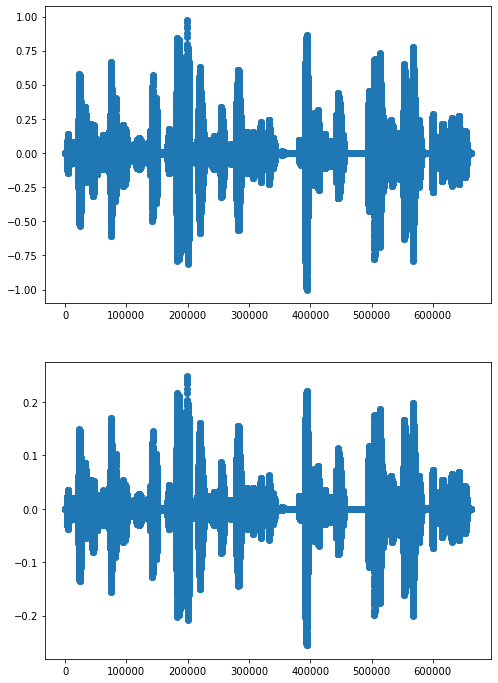

In [58]:
import seaborn as sns
#t = np.arange(len(y))

fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

#sns.scatterplot(x = np.arange(len(y)), y=y)
ax1.scatter(np.arange(len(x)), x[:,0])
ax2.scatter(np.arange(len(y)), y[:,0])

In [ ]:
#https://github.com/endolith/waveform_analysis/blob/master/waveform_analysis/weighting_filters/ABC_weighting.py#L29
# https://github.com/endolith/waveform_analysis/blob/master/waveform_analysis/weighting_filters/_filter_design.py

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 23 2014
Definitions from
 - ANSI S1.4-1983 Specification for Sound Level Meters, Section
   5.2 Weighting Networks, pg 5.
 - IEC 61672-1 (2002) Electroacoustics - Sound level meters,
   Part 1: Specification
"Above 20000 Hz, the relative response level shall decrease by at least 12 dB
per octave for any frequency-weighting characteristic"
Appendix C:
"it has been shown that the uncertainty allowed in the A-weighted frequency
response in the region above 16 kHz leads to an error which may exceed the
intended tolerances for the measurement of A-weighted sound level by a
precision (type 1) sound level meter."
"""

import numpy as np
from numpy import pi, log10
from scipy.signal import zpk2tf, zpk2sos, freqs, sosfilt
from scipy import signal
#from waveform_analysis.weighting_filters._filter_design import _zpkbilinear

__all__ = ['ABC_weighting', 'A_weighting', 'A_weight']


def ABC_weighting(curve='A'):
    """
    Design of an analog weighting filter with A, B, or C curve.
    Returns zeros, poles, gain of the filter.
    Examples
    --------
    Plot all 3 curves:
    >>> from scipy import signal
    >>> import matplotlib.pyplot as plt
    >>> for curve in ['A', 'B', 'C']:
    ...     z, p, k = ABC_weighting(curve)
    ...     w = 2*pi*logspace(log10(10), log10(100000), 1000)
    ...     w, h = signal.freqs_zpk(z, p, k, w)
    ...     plt.semilogx(w/(2*pi), 20*np.log10(h), label=curve)
    >>> plt.title('Frequency response')
    >>> plt.xlabel('Frequency [Hz]')
    >>> plt.ylabel('Amplitude [dB]')
    >>> plt.ylim(-50, 20)
    >>> plt.grid(True, color='0.7', linestyle='-', which='major', axis='both')
    >>> plt.grid(True, color='0.9', linestyle='-', which='minor', axis='both')
    >>> plt.legend()
    >>> plt.show()
    """
    if curve not in 'ABC':
        raise ValueError('Curve type not understood')

    # ANSI S1.4-1983 C weighting
    #    2 poles on the real axis at "20.6 Hz" HPF
    #    2 poles on the real axis at "12.2 kHz" LPF
    #    -3 dB down points at "10^1.5 (or 31.62) Hz"
    #                         "10^3.9 (or 7943) Hz"
    #
    # IEC 61672 specifies "10^1.5 Hz" and "10^3.9 Hz" points and formulas for
    # derivation.  See _derive_coefficients()

    z = [0, 0]
    p = [-2*pi*20.598997057568145,
         -2*pi*20.598997057568145,
         -2*pi*12194.21714799801,
         -2*pi*12194.21714799801]
    k = 1

    if curve == 'A':
        # ANSI S1.4-1983 A weighting =
        #    Same as C weighting +
        #    2 poles on real axis at "107.7 and 737.9 Hz"
        #
        # IEC 61672 specifies cutoff of "10^2.45 Hz" and formulas for
        # derivation.  See _derive_coefficients()

        p.append(-2*pi*107.65264864304628)
        p.append(-2*pi*737.8622307362899)
        z.append(0)
        z.append(0)

    elif curve == 'B':
        # ANSI S1.4-1983 B weighting
        #    Same as C weighting +
        #    1 pole on real axis at "10^2.2 (or 158.5) Hz"

        p.append(-2*pi*10**2.2)  # exact
        z.append(0)

    # TODO: Calculate actual constants for this
    # Normalize to 0 dB at 1 kHz for all curves
    b, a = zpk2tf(z, p, k)
    k /= abs(freqs(b, a, [2*pi*1000])[1][0])

    return np.array(z), np.array(p), k


def A_weighting(fs, output='ba'):
    """
    Design of a digital A-weighting filter.
    Designs a digital A-weighting filter for
    sampling frequency `fs`.
    Warning: fs should normally be higher than 20 kHz. For example,
    fs = 48000 yields a class 1-compliant filter.
    Parameters
    ----------
    fs : float
        Sampling frequency
    output : {'ba', 'zpk', 'sos'}, optional
        Type of output:  numerator/denominator ('ba'), pole-zero ('zpk'), or
        second-order sections ('sos'). Default is 'ba'.
    Examples
    --------
    Plot frequency response
    >>> from scipy.signal import freqz
    >>> import matplotlib.pyplot as plt
    >>> fs = 200000
    >>> b, a = A_weighting(fs)
    >>> f = np.logspace(np.log10(10), np.log10(fs/2), 1000)
    >>> w = 2*pi * f / fs
    >>> w, h = freqz(b, a, w)
    >>> plt.semilogx(w*fs/(2*pi), 20*np.log10(abs(h)))
    >>> plt.grid(True, color='0.7', linestyle='-', which='both', axis='both')
    >>> plt.axis([10, 100e3, -50, 20])
    Since this uses the bilinear transform, frequency response around fs/2 will
    be inaccurate at lower sampling rates.
    """
    z, p, k = ABC_weighting('A')

    # Use the bilinear transformation to get the digital filter.
    z_d, p_d, k_d = _zpkbilinear(z, p, k, fs)

    if output == 'zpk':
        return z_d, p_d, k_d
    elif output in {'ba', 'tf'}:
        return zpk2tf(z_d, p_d, k_d)
    elif output == 'sos':
        return zpk2sos(z_d, p_d, k_d)
    else:
        raise ValueError("'%s' is not a valid output form." % output)


def A_weight(signal, fs):
    """
    Return the given signal after passing through a digital A-weighting filter
    signal : array_like
        Input signal, with time as dimension
    fs : float
        Sampling frequency
    """
    # TODO: Upsample signal high enough that filter response meets Type 0
    # limits.  A passes if fs >= 260 kHz, but not at typical audio sample
    # rates. So upsample 48 kHz by 6 times to get an accurate measurement?
    # TODO: Also this could just be a measurement function that doesn't
    # save the whole filtered waveform.
    sos = A_weighting(fs, output='sos')
    return sosfilt(sos, signal)


def _derive_coefficients():
    """
    Calculate A- and C-weighting coefficients with equations from IEC 61672-1
    This is for reference only. The coefficients were generated with this and
    then placed in ABC_weighting().
    """
    import sympy as sp

    # Section 5.4.6
    f_r = 1000
    f_L = sp.Pow(10, sp.Rational('1.5'))  # 10^1.5 Hz
    f_H = sp.Pow(10, sp.Rational('3.9'))  # 10^3.9 Hz
    D = sp.sympify('1/sqrt(2)')  # D^2 = 1/2

    f_A = sp.Pow(10, sp.Rational('2.45'))  # 10^2.45 Hz

    # Section 5.4.9
    c = f_L**2 * f_H**2
    b = (1/(1-D))*(f_r**2+(f_L**2*f_H**2)/f_r**2-D*(f_L**2+f_H**2))

    f_1 = sp.sqrt((-b - sp.sqrt(b**2 - 4*c))/2)
    f_4 = sp.sqrt((-b + sp.sqrt(b**2 - 4*c))/2)

    # Section 5.4.10
    f_2 = (3 - sp.sqrt(5))/2 * f_A
    f_3 = (3 + sp.sqrt(5))/2 * f_A

    # Section 5.4.11
    assert abs(float(f_1) - 20.60) < 0.005
    assert abs(float(f_2) - 107.7) < 0.05
    assert abs(float(f_3) - 737.9) < 0.05
    assert abs(float(f_4) - 12194) < 0.5

    for f in ('f_1', 'f_2', 'f_3', 'f_4'):
        print('{} = {}'.format(f, float(eval(f))))

    # Section 5.4.8  Normalizations
    f = 1000
    C1000 = (f_4**2 * f**2)/((f**2 + f_1**2) * (f**2 + f_4**2))
    A1000 = (f_4**2 * f**4)/((f**2 + f_1**2) * sp.sqrt(f**2 + f_2**2) *
                             sp.sqrt(f**2 + f_3**2) * (f**2 + f_4**2))

    # Section 5.4.11
    assert abs(20*log10(float(C1000)) + 0.062) < 0.0005
    assert abs(20*log10(float(A1000)) + 2.000) < 0.0005

    for norm in ('C1000', 'A1000'):
        print('{} = {}'.format(norm, float(eval(norm))))
        
def _zpkbilinear(z, p, k, fs):
    """
    Return a digital filter from an analog one using a bilinear transform.
    Transform a set of poles and zeros from the analog s-plane to the digital
    z-plane using Tustin's method, which substitutes ``(z-1) / (z+1)`` for
    ``s``, maintaining the shape of the frequency response.
    Parameters
    ----------
    z : array_like
        Zeros of the analog IIR filter transfer function.
    p : array_like
        Poles of the analog IIR filter transfer function.
    k : float
        System gain of the analog IIR filter transfer function.
    fs : float
        Sample rate, as ordinary frequency (e.g. hertz). No prewarping is
        done in this function.
    Returns
    -------
    z : ndarray
        Zeros of the transformed digital filter transfer function.
    p : ndarray
        Poles of the transformed digital filter transfer function.
    k : float
        System gain of the transformed digital filter.
    """
    z = np.atleast_1d(z)
    p = np.atleast_1d(p)

    degree = _relative_degree(z, p)

    fs2 = 2.0*fs

    # Bilinear transform the poles and zeros
    z_z = (fs2 + z) / (fs2 - z)
    p_z = (fs2 + p) / (fs2 - p)

    # Any zeros that were at infinity get moved to the Nyquist frequency
    z_z = np.append(z_z, -np.ones(degree))

    # Compensate for gain change
    k_z = k * np.real(np.prod(fs2 - z) / np.prod(fs2 - p))

    return z_z, p_z, k_z

def _relative_degree(z, p):
    """
    Return relative degree of transfer function from zeros and poles
    """
    degree = len(p) - len(z)
    if degree < 0:
        raise ValueError("Improper transfer function. "
                         "Must have at least as many poles as zeros.")
    else:
        return degree

Text(0, 0.5, 'gain (dB)')

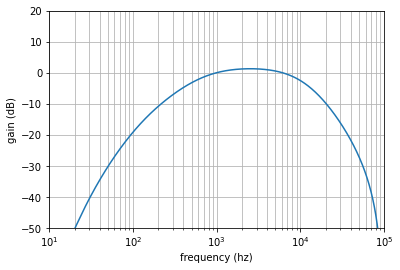

In [3]:
from scipy.signal import freqz
import matplotlib.pyplot as plt
fs = 200000
b, a = A_weighting(fs)
f = np.logspace(np.log10(10), np.log10(fs/2), 1000)
w = 2*pi * f / fs
w, h = freqz(b, a, w)
plt.semilogx(w*fs/(2*pi), 20*np.log10(abs(h)))
plt.grid(True, color='0.7', linestyle='-', which='both', axis='both')
plt.axis([10, 100e3, -50, 20])
plt.xlabel("frequency (hz)")
plt.ylabel("gain (dB)")
    